# Learning Switching Linear Dynamical Systems in Latent Space

In this notebook we show how to:
- Train a DCL model with a switching linear dynamical system.
- Analysis of the learned model, including the learned latent space and the learned dynamics.

In [1]:
from dcl.models.dynamics.slds import GumbelSLDS
from dcl.models.dynamics.linear_dynamics import LinearDynamicsModel
from dcl.models.dynamics.switching_dynamics import FixedMarkovSwitchingModel, MSESwitchingModel
from dcl.models.dynamics.utils import IdentityLDSParameters, RotationLDSParameters
from dcl.utils.rotation_matrix import MinMaxRotationSampler
from dcl.datasets.synthetic import SLDSDynamicsDataset
from dcl.loader.contrastive import DiscreteTimeContrastiveDataLoader
from dcl.solver.contrastive_solver import SLDSContrastiveLearningSolver
from dcl.models.mixing import NonlinearLinearMixingModel
from dcl.models.encoder import MLP
from dcl.metrics.utils import one_to_one_assignment
from dcl.distributions.time_distributions import (
    UniformDiscreteTimeDistribution,
    OffsetTimeDistribution,
)
from dcl.metrics.identifiability import R2
from dcl.metrics.dynamics import AccuracyViaHungarian, PredictiveMSE
from dcl.solver.optimizer import DCLAdamOptimizer
from dcl.criterions.contrastive import MseInfoNCE

from dcl.experiments.experiments import Experiment
from dcl.datasets.splits import TrialSplit
from dcl.utils.checkpoints import CheckpointSavingCallback

import torch
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys

sys.path.append("notebooks/")
from plotting import plot_embeddings_comparison

## Define dataset with nonlinear mixing

- We create a synthetic dataset with 6 latent dimensions, 5 modes, and a transition probability of 1e-2. We use a nonlinear mixing model to mix the latent dimensions into 50 observed dimensions.
- We create a dataset with 100 trials, each with 1000 time steps.

In [2]:
num_modes = 5
data_slds = GumbelSLDS(
    linear_dynamics=LinearDynamicsModel(
        dim=6,
        num_systems=num_modes,
        initializer=RotationLDSParameters(
            rotation_sampler=MinMaxRotationSampler(
                min_angle=0,
                max_angle=10,
            )),
        noise_std=1e-4),
    switching_model=FixedMarkovSwitchingModel(num_modes=num_modes,
                                              transition_probability=1e-2),
)

mixing_model = NonlinearLinearMixingModel(
    input_dim=data_slds.dim,
    output_dim=50,
    n_layers=4,
    n_iter_cond_thresh=int(1e5),
    cond_thresh_ratio=1e-4,
)

dataset = SLDSDynamicsDataset(
    #root='./datasets_notebooks',
    num_trials=100,
    num_steps=1000,
    dynamics_model=data_slds,
    mixing_model=mixing_model,
    force_regenerate=False,
)


Loaded SLDSDynamicsDataset from disk


## Visualization of the mode sequence of trials

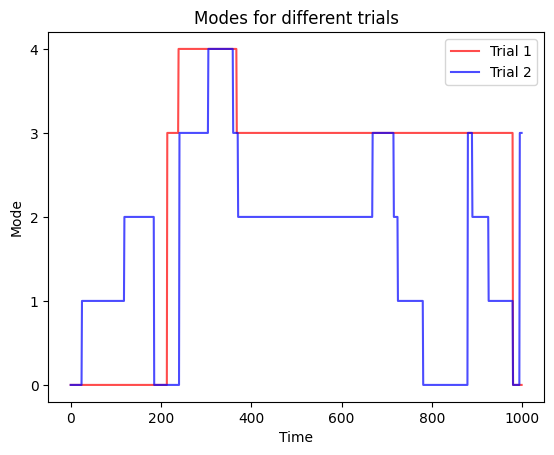

In [3]:
gt_data = dataset.ground_truth_data
plt.plot(gt_data.modes[:1000], label='Trial 1', color='red', alpha=0.7)
plt.plot(gt_data.modes[1000:2000], label='Trial 2', color='blue', alpha=0.7)
plt.yticks(range(num_modes))
plt.xlabel('Time')
plt.ylabel('Mode')
plt.title('Modes for different trials')
plt.legend()
plt.show()

## Visualzation of the observed / latent data for a single trial

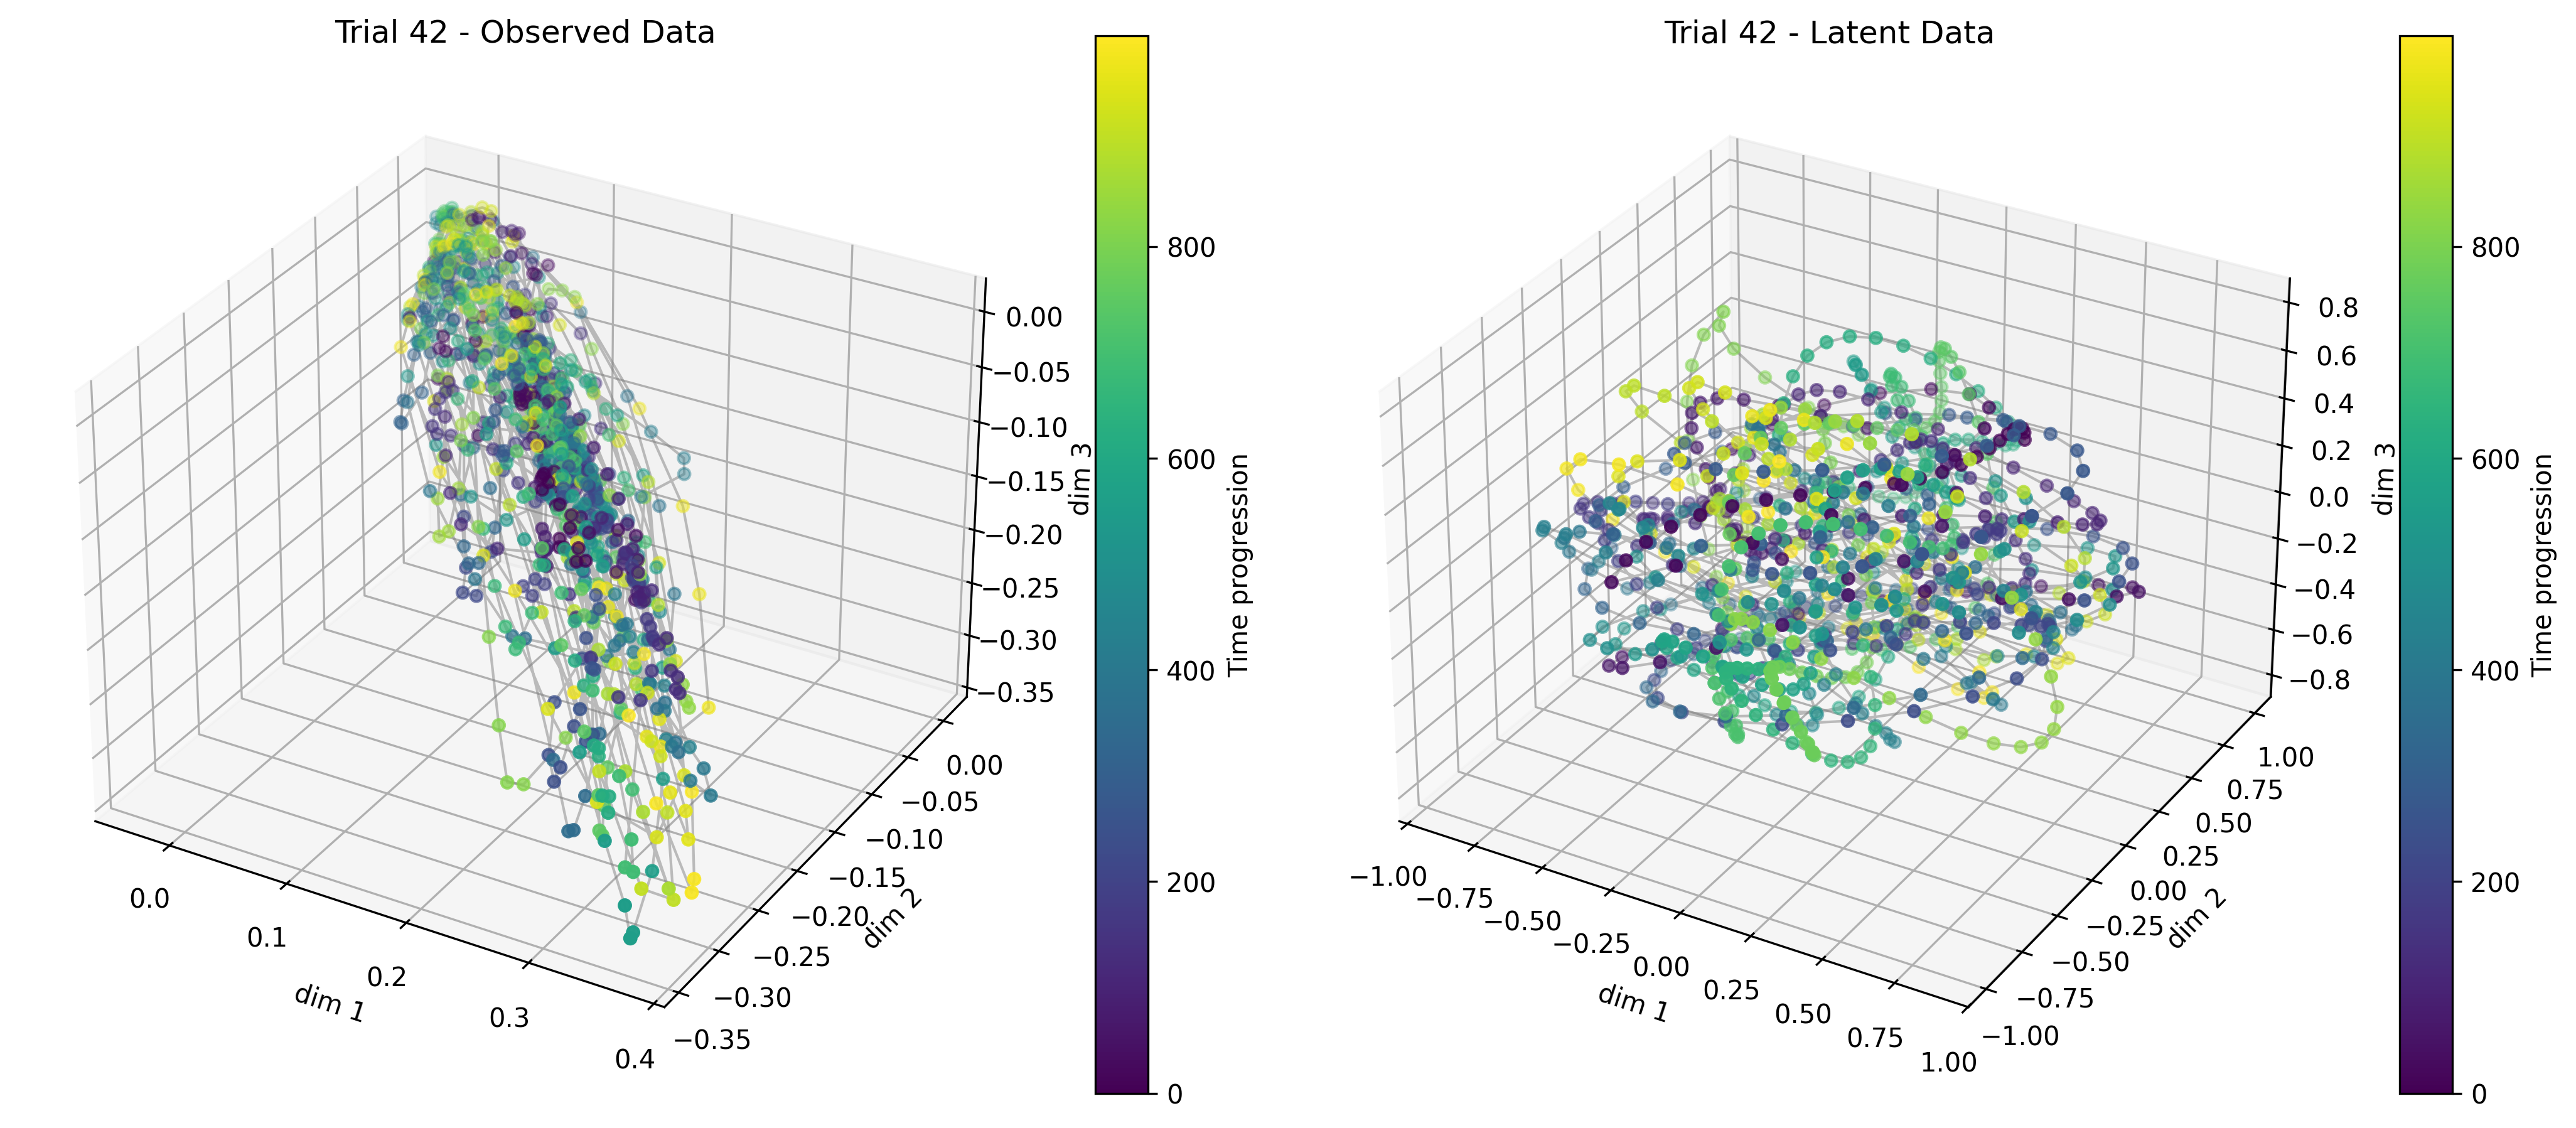

In [4]:
trial_id = 42

trial_mask = gt_data.auxilary.trial_id == trial_id
trial_gt_data = gt_data[trial_mask]

fig, (ax1, ax2) = plt.subplots(1,
                               2,
                               figsize=(14, 6),
                               dpi=300,
                               subplot_kw={'projection': '3d'})


def plot_3d_scatter_and_line(ax, data, title):
    scatter = ax.scatter(data[:, 0],
                         data[:, 1],
                         data[:, 2],
                         c=range(len(data)),
                         cmap='viridis')
    ax.plot(data[:, 0],
            data[:, 1],
            data[:, 2],
            color='gray',
            linewidth=1,
            alpha=0.5)
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.set_title(title)
    return scatter


# Plot for X
scatter_x = plot_3d_scatter_and_line(
    ax1,
    trial_gt_data.observed.detach().cpu().numpy(),
    f"Trial {trial_id} - Observed Data")
fig.colorbar(scatter_x, ax=ax1, label='Time progression')

# Plot for Z
scatter_z = plot_3d_scatter_and_line(
    ax2,
    trial_gt_data.latents.detach().cpu().numpy(),
    f"Trial {trial_id} - Latent Data")
fig.colorbar(scatter_z, ax=ax2, label='Time progression')

plt.tight_layout()
plt.show()
fig.colorbar(scatter_z, ax=ax2, label='Time progression')
plt.show()


## Lets build the different parts of the model and train it

### Define the data loader

In [5]:
loader = DiscreteTimeContrastiveDataLoader(
    num_iterations=30_000,
    batch_size=1024,
    batch_size_neg=2**14,
    reference_distribution=UniformDiscreteTimeDistribution(),
    positive_distribution=OffsetTimeDistribution(offset=1),
    negative_distribution=UniformDiscreteTimeDistribution(),
)
loader.lazy_init(dataset)

### Define the dynamics model

In [6]:
num_modes = 5
slds = GumbelSLDS(
    linear_dynamics=LinearDynamicsModel(
        dim=dataset.latent_dim,
        num_systems=num_modes,
        initializer=IdentityLDSParameters(),
    ),
    switching_model=MSESwitchingModel(num_modes=num_modes,),
)

### Define the solver

In [7]:
solver = SLDSContrastiveLearningSolver(
    model=MLP(
        input_dim=dataset.observed_dim,
        output_dim=dataset.latent_dim,
        hidden_dim=180,
        num_layers=3,
        normalize=False,
    ),
    dynamics_model=slds,
    optimizer=DCLAdamOptimizer(
        encoder_learning_rate=1e-3,
        dynamics_learning_rate=1e-3,
    ),
    criterion=MseInfoNCE(
        temperature=1.0,
        infonce_type="infonce_full_denominator",
    ),
    silence_metric_errors=False,
)

## Define and experiment and train the model

In [8]:
exp = Experiment(
    dataset=dataset,
    dataset_split=TrialSplit(train_ratio=0.8, test_ratio=0.1),
    solver=solver,
    train_loader=loader,
    name="slds_demo",
)

Loaded SLDSDynamicsDataset from disk
Loaded SLDSDynamicsDataset from disk
Loaded SLDSDynamicsDataset from disk


In [9]:
exp.run(eval_frequency=1000,
        eval_kwargs=dict(metrics=[
            AccuracyViaHungarian(),
            PredictiveMSE(),
            R2(bias=True, direction="backward"),
        ]),
        save_hook=CheckpointSavingCallback(save_step=10_000))

Training on device: cuda
Training with random seed: 42


Training:   0%|          | 0/30000 [00:00<?, ?iter/s]

logs/slds_demo/2025-06-18_10-59-35_75unk7/checkpoints/checkpoint_0010000 saved!
logs/slds_demo/2025-06-18_10-59-35_75unk7/checkpoints/checkpoint_0020000 saved!
logs/slds_demo/2025-06-18_10-59-35_75unk7/checkpoints/checkpoint_0030000 saved!
logs/slds_demo/2025-06-18_10-59-35_75unk7/checkpoints/last_checkpoint saved!


## Analyze the results

### Plot loss

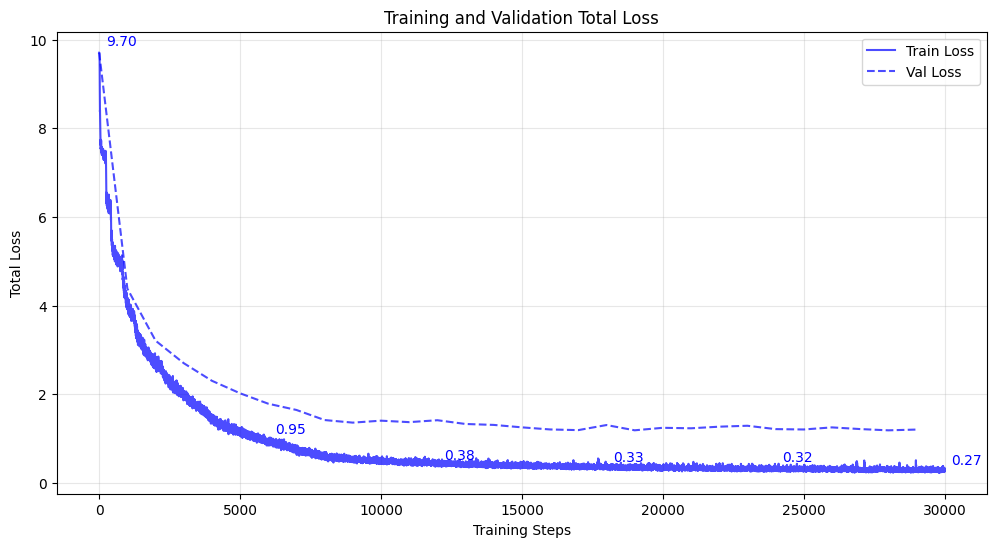

In [10]:
plt.figure(figsize=(12, 6))

# Plot training total loss
train_steps = range(len(exp.solver.logs['train_loss_total']))
plt.plot(train_steps,
         exp.solver.logs['train_loss_total'],
         color='blue',
         label='Train Loss',
         alpha=0.7)

# Plot validation total loss
val_steps = exp.solver.logs['val_step']
plt.plot(val_steps,
         exp.solver.logs['val_loss_total'],
         color='blue',
         label='Val Loss',
         linestyle='--',
         alpha=0.7)

# Add value labels at 500 step intervals for training total loss
for i in range(0, len(train_steps), int(len(train_steps) / 5)):
    plt.annotate(f'{exp.solver.logs["train_loss_total"][i]:.2f}',
                 (train_steps[i], exp.solver.logs['train_loss_total'][i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 color='blue')

# Add label for last training point if not already included
if (len(train_steps) - 1) % 500 != 0:
    plt.annotate(f'{exp.solver.logs["train_loss_total"][-1]:.2f}',
                 (train_steps[-1], exp.solver.logs['train_loss_total'][-1]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 color='blue')

plt.xlabel('Training Steps')
plt.ylabel('Total Loss')
plt.title('Training and Validation Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Evaluate the model on train and test set

In [11]:
exp.evaluate_train(metrics=[
    AccuracyViaHungarian(),
    PredictiveMSE(),
    R2(bias=True, direction="backward"),
],)

{'AccuracyViaHungarian': 0.9713588588588589,
 'PredictiveMSE': 0.11367013305425644,
 'R2_Backward_bias': 0.9885188937187195,
 'loss_align': 0.752547025680542,
 'loss_uniformity': -0.3854851722717285,
 'loss_total': 0.3670618534088135,
 'loss': 0.3670618534088135}

In [12]:
exp.evaluate_test(metrics=[
    AccuracyViaHungarian(),
    PredictiveMSE(),
    R2(bias=True, direction="backward"),
])

{'AccuracyViaHungarian': 0.9613249613249614,
 'PredictiveMSE': 0.1399424523115158,
 'R2_Backward_bias': 0.9882767796516418,
 'loss_align': 0.7294284701347351,
 'loss_uniformity': 0.2964925765991211,
 'loss_total': 1.025921106338501,
 'loss': 1.025921106338501}

## Plot the recovered embeddings

In [13]:
# forward pass of the model
val_gt_data = exp.val_loader.ground_truth_data
predictions = exp.solver.predictions(exp.val_loader)
gt_data.shape, predictions.shape

({'index': torch.Size([100000]),
  'observed': torch.Size([100000, 50]),
  'auxilary': {'trial_id': torch.Size([100000]),
   'trial_time': torch.Size([100000])},
  'latents': torch.Size([100000, 6]),
  'modes': torch.Size([100000])},
 {'embeddings': torch.Size([9000, 6]),
  'embeddings_index': torch.Size([9000]),
  'dynamics': {'x': torch.Size([8991, 6]),
   'x_index': torch.Size([8991]),
   'modes': torch.Size([8991])},
  'auxilary': {}})

Train backward R2: 0.987
Train forward R2: 0.988


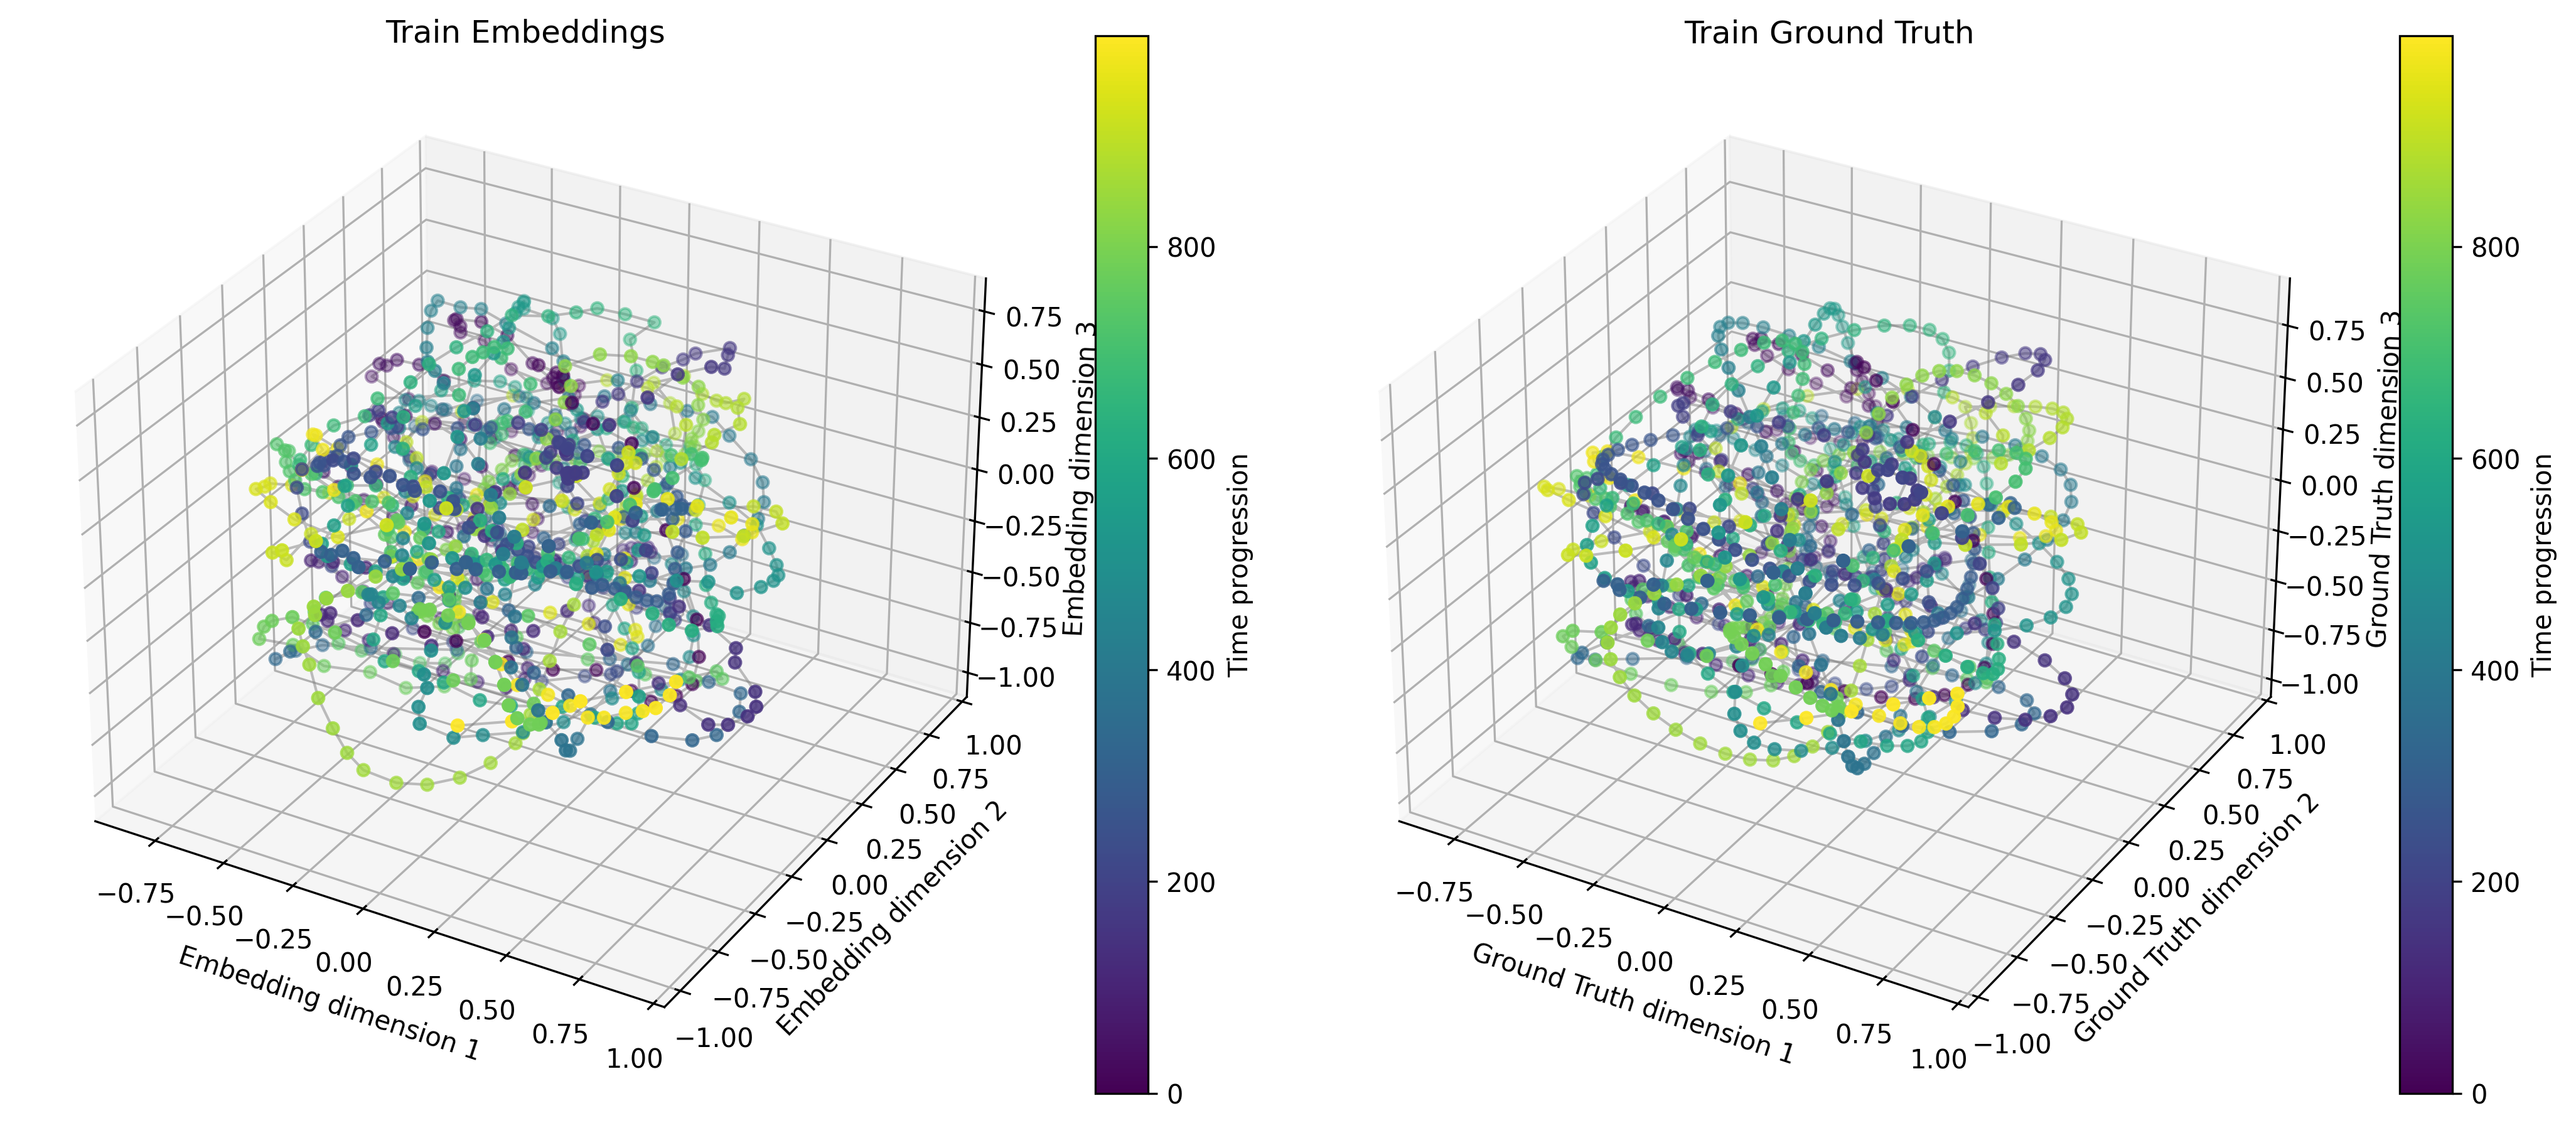

In [14]:
# Plot both training and validation
plot_embeddings_comparison(val_gt_data, predictions.embeddings, num_trials=1)

## Visualize the mode assignment


NOTE: The mode assigment will become less noisy if you train longer. 

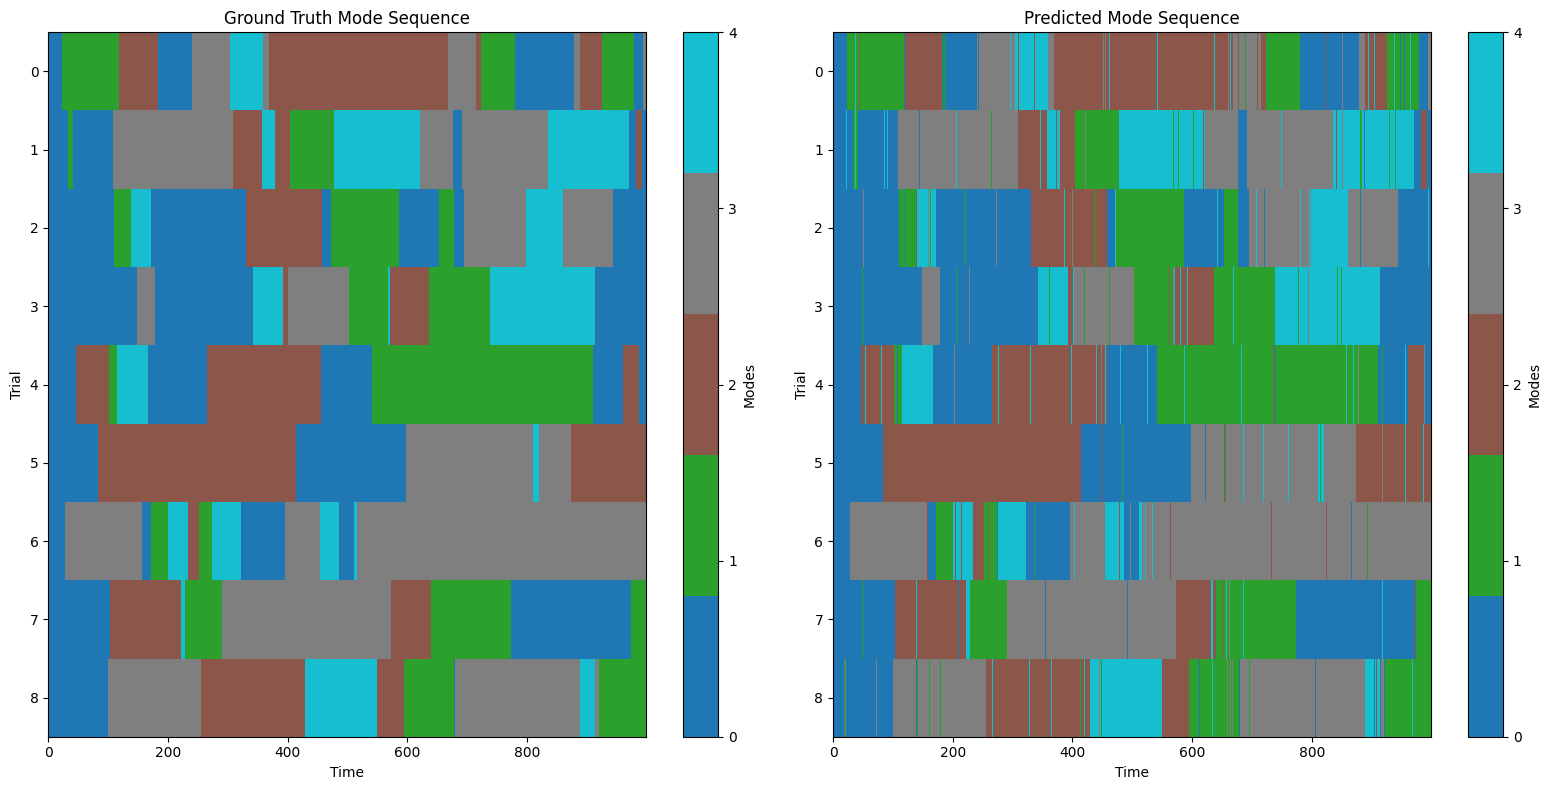

In [15]:
# Create a new array with reassigned mode labels based on the assignment dict
val_gt_data = exp.val_loader.ground_truth_data

unique_trials = torch.unique(val_gt_data.auxilary.trial_id)
x_index = predictions.dynamics.x_index
trials_pred_modes = predictions.dynamics.modes  #.reshape(len(unique_trials), -1)
val_gt_trial_modes = val_gt_data.modes[x_index]  #.reshape(len(unique_trials), -1)

# conver to numpy
trials_pred_modes = trials_pred_modes.detach().cpu().numpy()
val_gt_trial_modes = val_gt_trial_modes.detach().cpu().numpy()

assignment = one_to_one_assignment(val_gt_trial_modes,
                                   trials_pred_modes,
                                   num_classes=num_modes)

val_gt_data_modes = val_gt_trial_modes.reshape(len(unique_trials), -1)

trials_pred_modes_assigned = np.zeros_like(trials_pred_modes)
for old_label, new_label in assignment.items():
    trials_pred_modes_assigned[trials_pred_modes == old_label] = new_label

trials_pred_modes_assigned = trials_pred_modes_assigned.reshape(
    len(unique_trials), -1)

trials_pred_modes = trials_pred_modes.reshape(len(unique_trials), -1)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot ground truth modes
im1 = ax1.imshow(
    val_gt_data_modes,
    aspect='auto',
    cmap=plt.get_cmap('tab10', num_modes),  # Use a discrete colormap
    interpolation='none')
cbar = fig.colorbar(im1, ax=ax1, label='Modes', ticks=np.arange(num_modes))
ax1.set_xlabel('Time')
ax1.set_ylabel('Trial')
ax1.set_title('Ground Truth Mode Sequence')

# Plot predicted modes
im2 = ax2.imshow(
    trials_pred_modes_assigned,
    aspect='auto',
    cmap=plt.get_cmap('tab10', num_modes),  # Use a discrete colormap
    interpolation='none')
cbar = fig.colorbar(im2, ax=ax2, label='Modes', ticks=np.arange(num_modes))
ax2.set_xlabel('Time')
ax2.set_ylabel('Trial')
ax2.set_title('Predicted Mode Sequence')

plt.tight_layout()
plt.show()
